# Training and evaluation of model for PAI-scoring
2024.05.31 Gerald Torgersen
# Model: EfficientNet B7
# Data
- csv files with column for filename, PAI, weight
- RGB clips of radiographs centered around apex, 224 x 224 pixels

The weight in the data refers to the quality of scoring.

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import Counter
import time  # Import time to measure the duration of each epoch

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Normalize class labels to 0-based
        self.data['PAI'] = self.data['PAI'] - 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['filename']
        root_dir = self.data.iloc[idx]['root_dir']
        img_path = os.path.join(root_dir, img_name)
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
        else:
            raise FileNotFoundError(f"Image {img_name} not found in the root directory.")

        label = self.data.iloc[idx]['PAI']
        weight = self.data.iloc[idx]['weight']

        if self.transform:
            image = self.transform(image)

        return image, label, weight


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            print(f'Validation loss improved to {val_loss:.4f}, resetting counter.')
            return False
        else:
            self.counter += 1
            print(f'Validation loss did not improve. Counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True
            return False

# Function to save the checkpoint
def save_checkpoint(model, optimizer, epoch, filename):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, filename)

# Function to load the checkpoint
def load_checkpoint(model, optimizer, filename):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        return model, optimizer, start_epoch
    else:
        raise FileNotFoundError

# Enhanced data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Slight zoom in/out
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Translation and scaling
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.37887412, 0.37887412, 0.37887412], std=[0.09176591, 0.09176591, 0.09176591])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.37887412, 0.37887412, 0.37887412], std=[0.09176591, 0.09176591, 0.09176591])
    ]),
}

In [ ]:
# Load and combine data one ore more datasets
all_data = pd.DataFrame()
csv_files = ["path1/data1.csv", "path2/data2.csv"] # Replace with your csv paths
root_dirs = ["images_path1", "images_path2"] # Replace with your image paths

for csv_file, root_dir in zip(csv_files, root_dirs):
    data = pd.read_csv(csv_file)
    data['root_dir'] = root_dir  # Add the root directory to the dataframe
    all_data = pd.concat([all_data, data], ignore_index=True)

# Split the combined dataset into training and validation sets
train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=42, stratify=all_data['PAI'])

In [ ]:
# Function to display dataset statistics
def display_dataset_statistics(data, name):
    class_counts = Counter(data['PAI'])
    total_samples = len(data)
    class_percentages = {cls: count / total_samples * 100 for cls, count in class_counts.items()}

    stats_df = pd.DataFrame({
        'Class': list(class_counts.keys()),
        'Count': list(class_counts.values()),
        'Percentage (%)': [f"{percentage:.1f}" for percentage in class_percentages.values()]
    })

    print(f"\nStatistics for {name} set:")
    print(stats_df)

# Display statistics for training and validation sets
display_dataset_statistics(all_data, 'All data')  # Using the balanced training data


Statistics for All data set:
   Class  Count Percentage (%)
0      1    231           20.6
1      3    465           41.4
2      2    187           16.7
3      5     55            4.9
4      4    185           16.5


In [ ]:
# Handle unbalanced data by ramdom oversampling

from imblearn.over_sampling import RandomOverSampler

# Oversample the training data
ros = RandomOverSampler(random_state=42)
train_data_resampled, _ = ros.fit_resample(train_data, train_data['PAI'])

# Function to create weighted sampler
def create_weighted_sampler(data):
    weights = data['weight'].values
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

# Create datasets
train_dataset = CustomDataset(train_data_resampled, transform=data_transforms['train'])
val_dataset = CustomDataset(val_data, transform=data_transforms['val'])

train_sampler = create_weighted_sampler(train_data_resampled)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Training dataset size: 1860
Validation dataset size: 225


In [ ]:
# Function to display dataset statistics
def display_dataset_statistics(data, name):
    class_counts = Counter(data['PAI'])
    total_samples = len(data)
    class_percentages = {cls: count / total_samples * 100 for cls, count in class_counts.items()}

    stats_df = pd.DataFrame({
        'Class': list(class_counts.keys()),
        'Count': list(class_counts.values()),
        'Percentage (%)': [f"{percentage:.1f}" for percentage in class_percentages.values()]
    })

    print(f"\nStatistics for {name} set:")
    print(stats_df)

# Display statistics for training and validation sets
display_dataset_statistics(train_data_resampled, 'Training')  # Using the balanced training data
display_dataset_statistics(val_data, 'Validation')



Statistics for Training set:
   Class  Count Percentage (%)
0      3    372           20.0
1      4    372           20.0
2      2    372           20.0
3      1    372           20.0
4      0    372           20.0

Statistics for Validation set:
   Class  Count Percentage (%)
0      0     46           20.4
1      2     93           41.3
2      3     37           16.4
3      1     38           16.9
4      4     11            4.9


In [ ]:
from torchvision.models import efficientnet_b7

# Load and modify the EfficientNet model
model = efficientnet_b7(pretrained=True)
check_point_path = 'EfficientNet_model_b7_checkpoint.pth'

n = 3  # Number of blocks to unfreeze

for name, param in model.named_parameters():
    if any(f"features.{i}" in name for i in range(n, len(list(model.features)))):
        param.requires_grad = True
    elif "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),  # Add dropout for regularization
    nn.Linear(num_features, 5)  # Assuming 5 classes
)


# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the criterion
criterion = nn.CrossEntropyLoss(reduction='none')

# Define optimizer, scheduler, and loss function
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Early stopping class (assuming it's defined as before)
early_stopping = EarlyStopping(patience=10, min_delta=0.00001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 219MB/s]


In [ ]:
# Lists to collect training data
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []
mae_list = []

In [ ]:
# Path to save the checkpoint
check_point_path = 'model_checkpoint.pth'

# Initialize start_epoch and total_epochs
start_epoch = 0
total_epochs = 40

# Attempt to load checkpoint
try:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, check_point_path)
    total_epochs = start_epoch + 10
except FileNotFoundError:
    start_epoch = 0
    total_epochs = 40
    print("No checkpoint found. Starting training from scratch.")

# Lists to store the probabilities for each class
all_probs = []
all_true_labels = []

for epoch in range(start_epoch, total_epochs):
    epoch_start_time = time.time()  # Start timing the epoch
    print(f'Starting epoch {epoch+1}/{total_epochs}')

    train_loss = 0.0
    train_corrects = 0
    val_loss = 0.0
    val_corrects = 0

    all_probs = []
    all_true_labels = []

    model.train()
    for batch_idx, (inputs, labels, weights) in enumerate(train_loader):
        inputs, labels, weights = inputs.to(device), labels.to(device), weights.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        weighted_loss = (loss * weights).mean()  # Apply weights to the loss
        weighted_loss.backward()
        optimizer.step()

        train_loss += weighted_loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)

    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, labels, _) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.mean().item() * inputs.size(0)  # Use mean for validation loss
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

            # Collect true labels and probabilities for each class
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    mae = mean_absolute_error(all_true_labels, [np.argmax(p) for p in all_probs])
    mae_list.append(mae)

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_corrects.double() / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch+1}/{total_epochs} - '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}, '
          f'MAE: {mae:.4f}')

    save_checkpoint(model, optimizer, epoch + 1, check_point_path)

    if early_stopping(val_loss):
        print("Early stopping")
        break

    scheduler.step()

No checkpoint found. Starting training from scratch.
Starting epoch 1/40
Epoch 1/40 - Train Loss: 9.5281, Train Accuracy: 0.3710, Validation Loss: 1.6372, Validation Accuracy: 0.2444, MAE: 1.2933
Validation loss improved to 1.6372, resetting counter.
Starting epoch 2/40
Epoch 2/40 - Train Loss: 5.0527, Train Accuracy: 0.5839, Validation Loss: 1.7342, Validation Accuracy: 0.2400, MAE: 1.1911
Validation loss did not improve. Counter: 1/10
Starting epoch 3/40
Epoch 3/40 - Train Loss: 2.8355, Train Accuracy: 0.7000, Validation Loss: 1.5552, Validation Accuracy: 0.3556, MAE: 0.9867
Validation loss improved to 1.5552, resetting counter.
Starting epoch 4/40
Epoch 4/40 - Train Loss: 1.9969, Train Accuracy: 0.7715, Validation Loss: 1.6928, Validation Accuracy: 0.3289, MAE: 0.9467
Validation loss did not improve. Counter: 1/10
Starting epoch 5/40
Epoch 5/40 - Train Loss: 1.6274, Train Accuracy: 0.7817, Validation Loss: 1.6609, Validation Accuracy: 0.4311, MAE: 0.8178
Validation loss did not impr

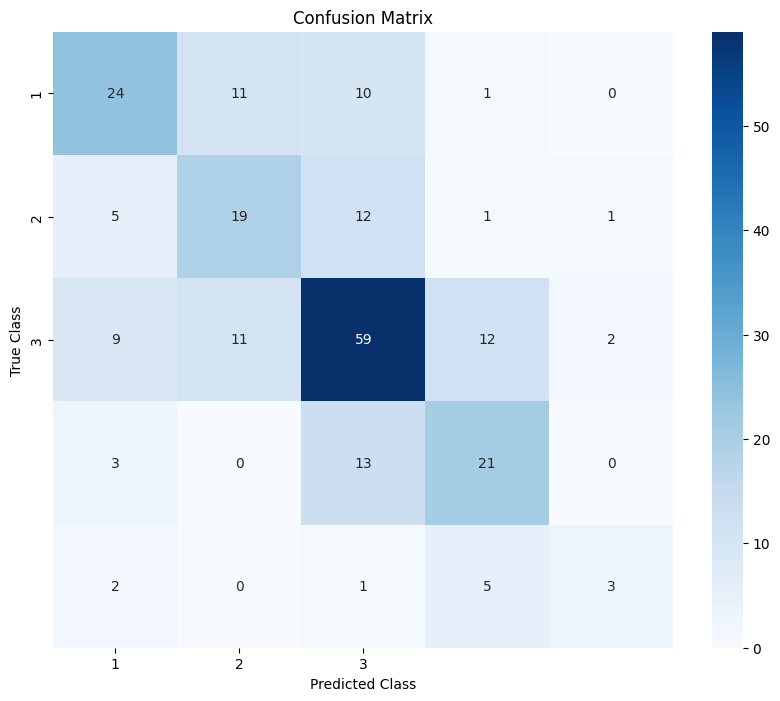

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

num_classes = 3

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, [np.argmax(p) for p in all_probs])

# Adjust the labels to start from 1 instead of 0
labels = range(1, num_classes + 1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


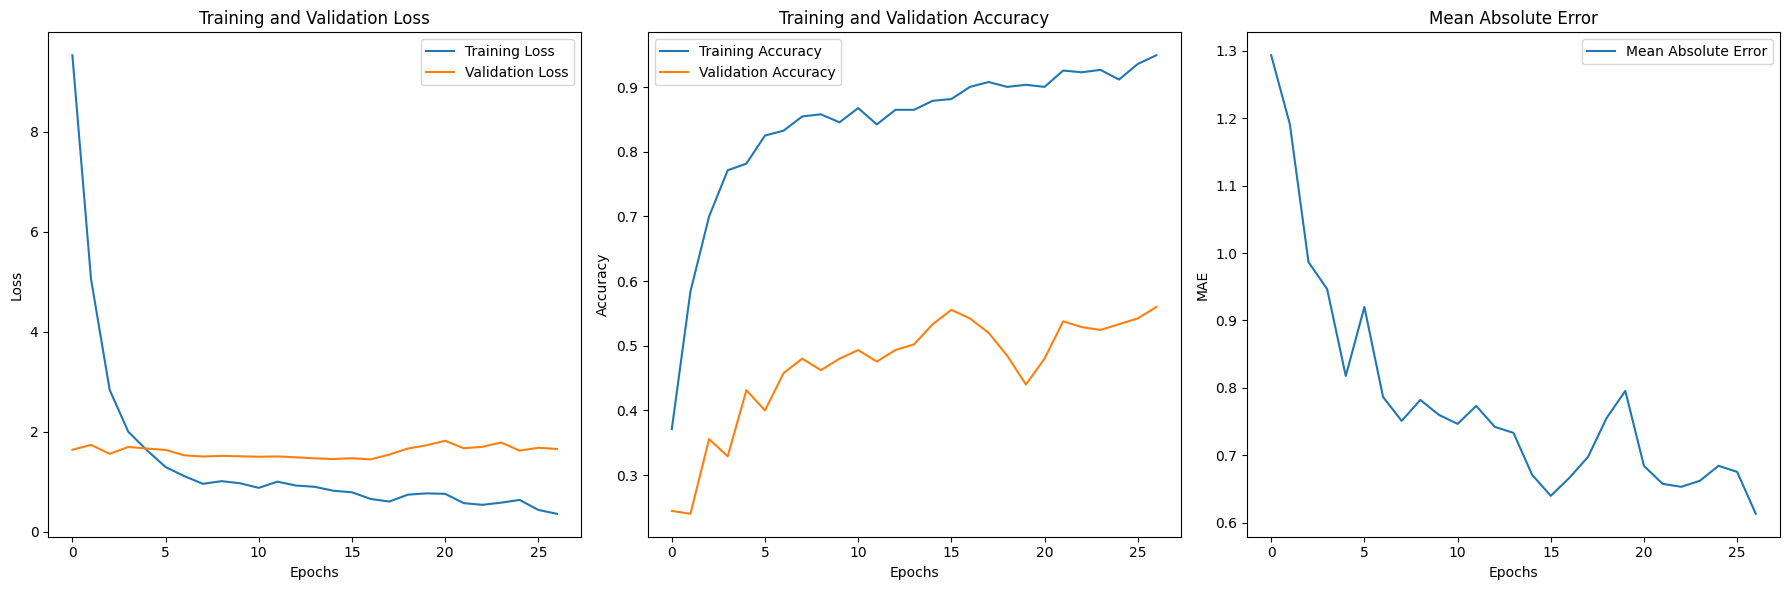

In [ ]:
# Ensure all elements are floats
train_loss_list = [loss.item() if torch.is_tensor(loss) else loss for loss in train_loss_list]
val_loss_list = [loss.item() if torch.is_tensor(loss) else loss for loss in val_loss_list]
train_accuracy_list = [accuracy.cpu().numpy() if torch.is_tensor(accuracy) else accuracy for accuracy in train_accuracy_list]
val_accuracy_list = [accuracy.cpu().numpy() if torch.is_tensor(accuracy) else accuracy for accuracy in val_accuracy_list]

# Plot training and validation loss
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(len(train_loss_list)), train_loss_list, label='Training Loss')
plt.plot(range(len(val_loss_list)), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(range(len(train_accuracy_list)), train_accuracy_list, label='Training Accuracy')
plt.plot(range(len(val_accuracy_list)), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot mean absolute error
plt.subplot(1, 3, 3)
plt.plot(range(len(mae_list)), mae_list, label='Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error')

plt.tight_layout()
plt.show()


In [ ]:
def run_inference(model, dataloader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for inputs, labels, weights in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # Collect data
            for i in range(inputs.size(0)):
                filename = dataloader.dataset.data.iloc[i]['filename']
                true_pai = labels[i].item() + 1  # Converting back to 1-based index
                predicted_pai = preds[i].item() + 1  # Converting back to 1-based index
                probability = probs[i][preds[i]].item()

                results.append({
                    'filename': filename,
                    'true_pai': true_pai,
                    'predicted_pai': predicted_pai,
                    'probability': probability
                })
    return results

# Run inference on the validation dataset
results = run_inference(model, val_loader, device)

# Print the results
for result in results:
    print(f"Filename: {result['filename']}, True PAI: {result['true_pai']}, Predicted PAI: {result['predicted_pai']}, Probability: {result['probability']:.4f}")

Filename: D_681.png, True PAI: 1, Predicted PAI: 3, Probability: 0.6498
Filename: D_32.png, True PAI: 1, Predicted PAI: 1, Probability: 0.9708
Filename: S_536.png, True PAI: 3, Predicted PAI: 3, Probability: 0.9572
Filename: D_71.png, True PAI: 4, Predicted PAI: 4, Probability: 0.9707
Filename: G_120.png, True PAI: 3, Predicted PAI: 3, Probability: 0.6029
Filename: D_6.png, True PAI: 3, Predicted PAI: 3, Probability: 0.9694
Filename: S_40.png, True PAI: 2, Predicted PAI: 2, Probability: 0.9957
Filename: D_421.png, True PAI: 5, Predicted PAI: 1, Probability: 0.5784
Filename: S_308.png, True PAI: 2, Predicted PAI: 2, Probability: 0.7092
Filename: G_31.png, True PAI: 1, Predicted PAI: 1, Probability: 0.9808
Filename: S_271.png, True PAI: 3, Predicted PAI: 3, Probability: 0.7430
Filename: G_125.png, True PAI: 4, Predicted PAI: 3, Probability: 0.6058
Filename: D_679.png, True PAI: 4, Predicted PAI: 4, Probability: 0.4956
Filename: D_34.png, True PAI: 3, Predicted PAI: 3, Probability: 0.9310

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv('results.csv', index=False)

In [ ]:
# Assuming 'model' is your fine-tuned model
model_path = 'path to save model'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")